In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import numpy as np
from patsy import dmatrix
from matplotlib import cm
%matplotlib inline
np.set_printoptions(precision=4, suppress=True)

In [2]:
df = pd.read_csv("../data/South African Heart Disease.txt")
names = ['sbp', 'tobacco', 'ldl', 'famhist', 'obesity', 'alcohol', 'age']
df['famhist'] = pd.get_dummies(df['famhist'])['Present']
df.head()

,row.names,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,1,160,12.00,5.73,23.11,1,49,25.30,97.20,52,1
1,2,144,0.01,4.41,28.61,0,55,28.87,2.06,63,1
2,3,118,0.08,3.48,32.28,1,52,29.14,3.81,46,0
3,4,170,7.50,6.41,38.03,1,51,31.99,24.26,58,1
4,5,134,13.60,3.50,27.78,1,60,25.99,57.34,49,1


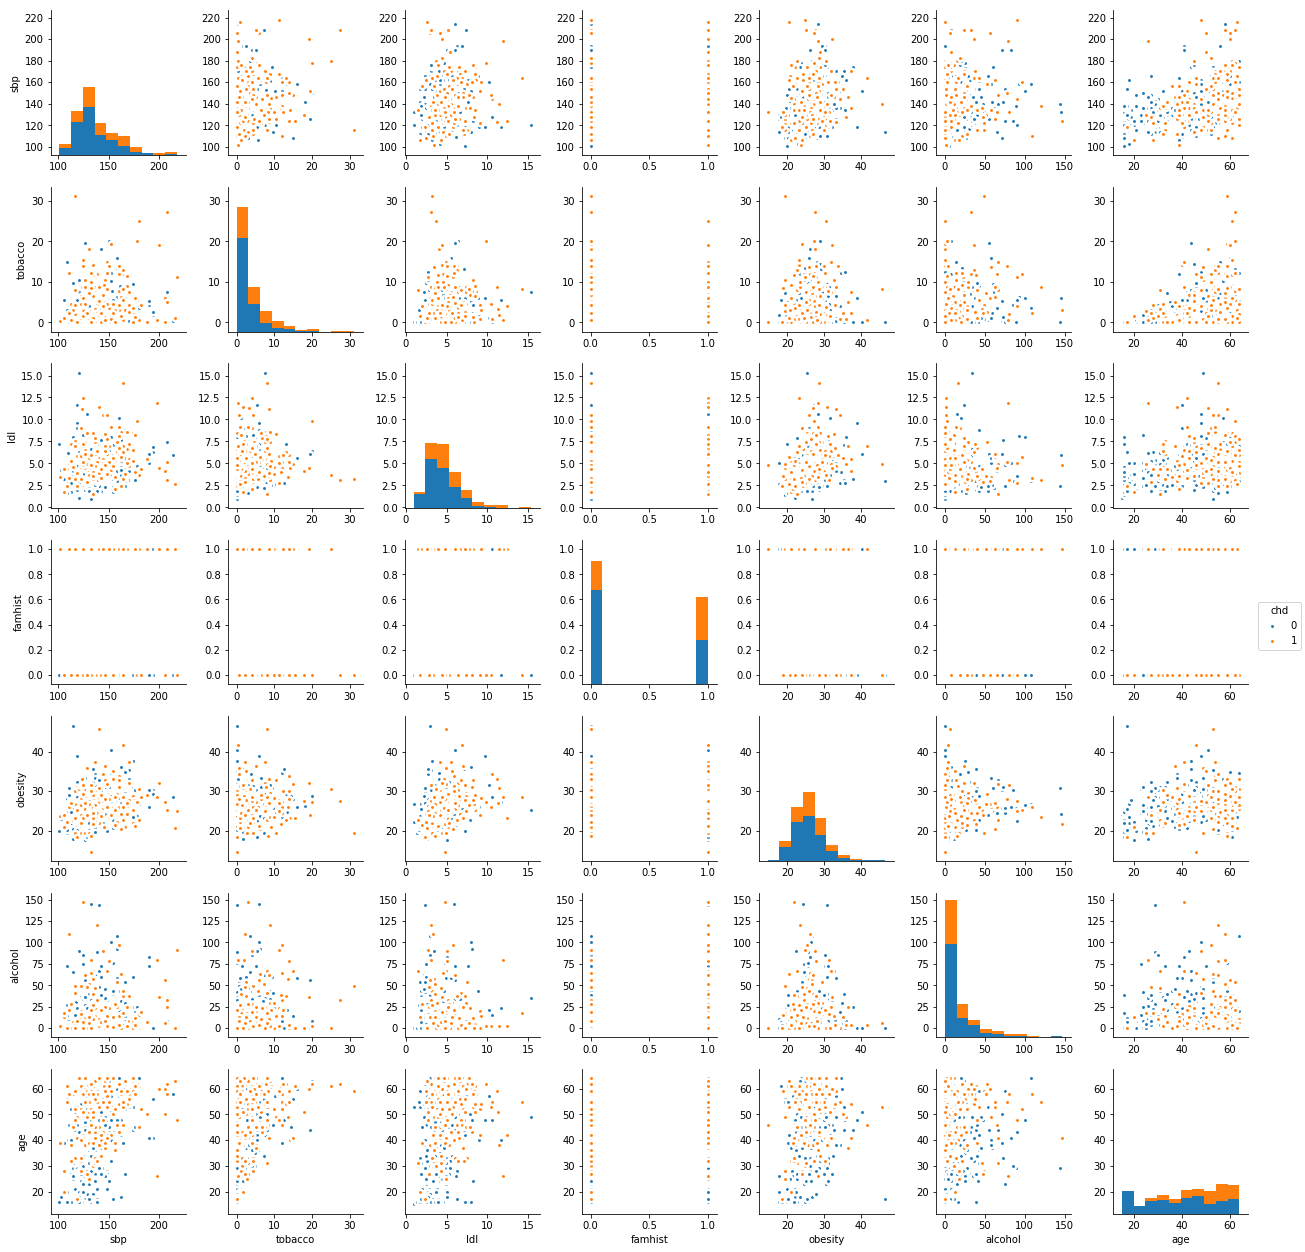

In [3]:
sns.pairplot(df, vars=names, kind="scatter", hue="chd", plot_kws=dict(s=30, edgecolor="white", linewidth=2.5))

In [4]:
X, y = df[names].values, df[['chd']].values

In [5]:
ls = sm.Logit(y, sm.add_constant(X)).fit(disp=False)
print(ls.summary(xname=['(Intercept)'] + names))

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  462
Model:                          Logit   Df Residuals:                      454
Method:                           MLE   Df Model:                            7
Date:                Wed, 06 Feb 2019   Pseudo R-squ.:                  0.1895
Time:                        09:16:24   Log-Likelihood:                -241.59
converged:                       True   LL-Null:                       -298.05
                                        LLR p-value:                 2.259e-21
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
(Intercept)    -4.1296      0.964     -4.283      0.000      -6.019      -2.240
sbp             0.0058      0.006      1.023      0.306      -0.005       0.017
tobacco         0.0795      0.026      3.034    

<h4>Forward-Stepwise Selection</h4>

In [6]:
data = df[names]
remaining, selected, best_model = set(data.columns), [], None
while remaining:
    scores = []
    for candidate in remaining:
        X = data[selected + [candidate]].values
        model = sm.Logit(y, sm.add_constant(X)).fit(disp=False)
        scores.append((model.pvalues[-1], candidate, model))
    scores.sort()
    best_score = scores[0]
    if best_score[0] > 0.05:
        break
    best_model = best_score[2]
    remaining.remove(best_score[1])
    selected.append(best_score[1])

In [7]:
print(best_model.summary(xname=['(Intercept)'] + selected))

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  462
Model:                          Logit   Df Residuals:                      457
Method:                           MLE   Df Model:                            4
Date:                Wed, 06 Feb 2019   Pseudo R-squ.:                  0.1856
Time:                        09:16:24   Log-Likelihood:                -242.72
converged:                       True   LL-Null:                       -298.05
                                        LLR p-value:                 5.251e-23
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
(Intercept)    -4.2043      0.498     -8.436      0.000      -5.181      -3.228
age             0.0440      0.010      4.520      0.000       0.025       0.063
famhist         0.9241      0.223      4.141    

<h4>L1 Regularized Logistic Regression</h4>

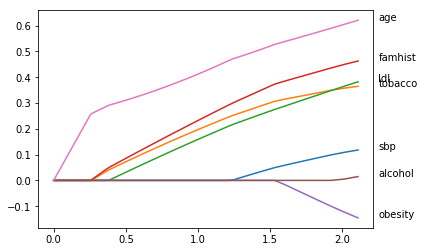

In [8]:
X, y = df[names].values, df[['chd']].values
X = StandardScaler().fit(X).transform(X)
result = []
for alpha in range(1000):
    ls = sm.Logit(y, sm.add_constant(X)).fit_regularized(disp=False, alpha=alpha)
    b_hat = ls.params[1:]
    result.append((np.sum(np.abs(b_hat)), b_hat))
    if b_hat @ b_hat == 0:
        break
result = sorted(result)
plot_x = [e[0] for e in result]
plot_y = np.vstack([e[1] for e in result])
for i in range(7):
    plt.plot(plot_x, plot_y[:,i])
    plt.text(2.25, plot_y[-1,i], names[i])

<h4>Natural-Spline Basis Expansion</h4>

In [9]:
y = df[['chd']].values
# TODO: use patsy instead
def dk(x, xi_k, xi_K):
    return (max(0, x-xi_k)**3 - max(0, x-xi_K)**3) / (xi_K-xi_k)

def do_nc_expansion(x, xi1, xi2, xi3, xi4, xi5):
    X = np.zeros(shape=(x.shape[0], 4))
    for i in range(X.shape[0]):
        X[i, 0] = x[i]
        X[i, 1] = dk(x[i], xi1, xi5) - dk(x[i], xi4, xi5)
        X[i, 2] = dk(x[i], xi2, xi5) - dk(x[i], xi4, xi5)
        X[i, 3] = dk(x[i], xi3, xi5) - dk(x[i], xi4, xi5)
    return X

def get_X_expanded(names):
    X = df[names].values
    X_ = np.ones(shape=(X.shape[0], 1))
    for i, name in enumerate(names):
        if name == 'famhist':
            e = X[:, i].reshape((X.shape[0], 1))
        else:
            knots = np.quantile(X[:,i], (0, 0.25, 0.5, 0.75, 1))
            e = do_nc_expansion(X[:,i], *knots)
        X_ = np.hstack((X_, e))
    return X_

In [10]:
names_left = names[:]
X = get_X_expanded(names_left)
current_ls = sm.Logit(y, X).fit(disp=False)
current_aic = current_ls.aic
while True:
    print('current AIC', current_aic)
    bcwd = []
    for name in names_left:
        test_names = names_left[:]
        test_names.remove(name)
        bcwd.append((sm.Logit(y, get_X_expanded(test_names)).fit(disp=False).aic, name))
    best_aic, best_exclude_name = sorted(bcwd)[0]
    if best_aic < current_aic:
        current_aic = best_aic
        names_left.remove(best_exclude_name)
    else:
        break

current AIC 509.63178580353764
current AIC 502.0879440997786


In [11]:
bcwd

[(503.1641493465693, 'sbp'),
 (506.4752593818633, 'tobacco'),
 (508.3944580417449, 'ldl'),
 (521.4440963087994, 'famhist'),
 (502.2350412213343, 'obesity'),
 (517.8561396226274, 'age')]

In [12]:
name_df = {'sbp': 4, 'tobacco': 4, 'ldl': 4, 'famhist': 1, 'obesity': 4, 'alcohol': 4, 'age': 4}
dfs = [1] + [name_df[n] for n in names_left]
list(zip(['intercept'] + names_left, dfs))

[('intercept', 1),
 ('sbp', 4),
 ('tobacco', 4),
 ('ldl', 4),
 ('famhist', 1),
 ('obesity', 4),
 ('age', 4)]

In [13]:
X = get_X_expanded(names_left)
ls = sm.Logit(y, X).fit(disp=False)
cut_idx = np.cumsum(dfs)[:-1]
th = np.split(ls.params, cut_idx)
h = np.split(X, cut_idx, axis=1)

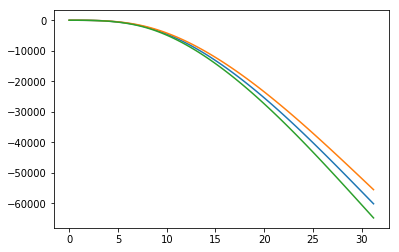

In [14]:
p = 2
X_p = h[p][:, 0]
X_p = np.linspace(min(X_p), max(X_p), 100)
knots = np.quantile(X_p, (0, 0.25, 0.5, 0.75, 1))
X_p_ = do_nc_expansion(X_p, *knots)
cv_p = [np.split(np.split(ls.cov_params(), cut_idx, axis=1)[i], cut_idx, axis=0)[i] for i in range(len(cut_idx)+1)][p]
plt.plot(X_p, X_p_ @ th[p])
_2sigma = 2 * np.sqrt(np.diagonal((X_p_ @ cv_p @ X_p_.T))/462)
plt.plot(X_p, X_p_ @ th[p] + _2sigma)
plt.plot(X_p, X_p_ @ th[p] - _2sigma)

In [123]:
from scipy.interpolate import SmoothBivariateSpline
from scipy.interpolate import Rbf
from scipy.spatial import ConvexHull

def point_in_hull(point, hull, tolerance=1e-12):
    return all(
        (np.dot(eq[:-1], point) + eq[-1] <= tolerance)
        for eq in hull.equations)

In [133]:
df1 = df[df.chd == 1]

In [242]:
x, y, z = df.age.values, df.obesity, df.sbp
hull = ConvexHull(np.hstack((df1.age.values.reshape(df1.age.values.shape[0], 1), df1.obesity.values.reshape(df1.obesity.values.shape[0], 1))))

In [243]:
sbs = SmoothBivariateSpline(x, y, z, s=10000000)
rbf = Rbf(x, y, z, smooth=80)

In [244]:
xi, yi = np.meshgrid(np.linspace(15, 65, 100), np.linspace(10, 47, 100))
zi = rbf(xi, yi)
for i in range(xi.shape[0]):
    for j in range(xi.shape[1]):
        if not point_in_hull([xi[i, j], yi[i, j]], hull):
            zi[i, j] = None

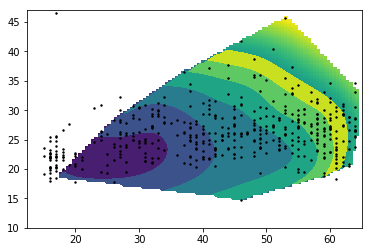

In [248]:
c = plt.pcolormesh(xi, yi, zi)
plt.contourf(xi, yi, zi, levels=[125, 130, 135, 140, 145, 150, 155])
plt.scatter(df.age.values, df.obesity.values, s=2, c='black')

In [204]:
zi[50, 50]

179.5914090761803